<a href="https://colab.research.google.com/github/twillightsparkle/Stock-prediction/blob/main/Stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

#Read the file to panda
df = pd.read_csv('FPT.csv')

df

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410,0
1,FPT,12/25/2018 9:16,30.81,30.81,30.81,30.81,190,0
2,FPT,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120,0
3,FPT,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120,0
4,FPT,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500,0
...,...,...,...,...,...,...,...,...
97401,FPT,12/22/2020 14:24,58.20,58.20,58.20,58.20,27470,0
97402,FPT,12/22/2020 14:25,58.20,58.20,58.20,58.20,14820,0
97403,FPT,12/22/2020 14:26,58.20,58.20,58.20,58.20,500,0
97404,FPT,12/22/2020 14:29,58.10,58.10,58.10,58.10,2500,0


In [ ]:
#Keep only the column of Date and close price
df = df[['Date/Time', 'Close']]

df

,Date/Time,Close
0,12/25/2018 9:15,30.89
1,12/25/2018 9:16,30.81
2,12/25/2018 9:17,30.74
3,12/25/2018 9:18,30.74
4,12/25/2018 9:19,30.74
...,...,...
97401,12/22/2020 14:24,58.20
97402,12/22/2020 14:25,58.20
97403,12/22/2020 14:26,58.20
97404,12/22/2020 14:29,58.10


In [ ]:
import datetime

#This function turn string into datetime object
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [ ]:
# Convert Datetime column to pandas datetime format
df["Date/Time"] = pd.to_datetime(df["Date/Time"])

<ipython-input-4-3cb2444450bb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date/Time"] = pd.to_datetime(df["Date/Time"])


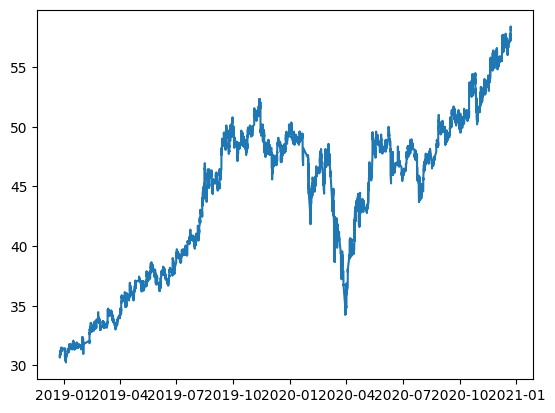

In [ ]:
import matplotlib.pyplot as plt

#Ploting data
plt.plot(df['Date/Time'], df['Close'])

In [ ]:
#Reformat date and time to only date, fill in missing date
def fill_missing_dates(df):
  # Extract the date only
  df["Date"] = df["Date/Time"].dt.date

  # Group by date and calculate the daily average closing price
  daily_avg = df.groupby("Date")["Close"].mean().reset_index()

  # Create a complete date range from the minimum to the maximum date
  date_range = pd.date_range(start=daily_avg["Date"].min(), end=daily_avg["Date"].max())

  # Reindex the DataFrame to include all dates in the range
  daily_avg = daily_avg.set_index("Date").reindex(date_range).rename_axis("Date").reset_index()

  # Fill missing values by averaging the previous and next day's closing price
  daily_avg["Close"] = daily_avg["Close"].interpolate(method="linear")

  #give the dataframe back to df
  df = daily_avg
  return df
df = fill_missing_dates(df)
df

<ipython-input-6-f3b6a96cca9d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = df["Date/Time"].dt.date


,Date,Close
0,2018-12-25,30.760000
1,2018-12-26,31.050159
2,2018-12-27,31.331567
3,2018-12-28,31.321557
4,2018-12-29,31.303725
...,...,...
724,2020-12-18,56.811268
725,2020-12-19,57.003462
726,2020-12-20,57.195656
727,2020-12-21,57.387850


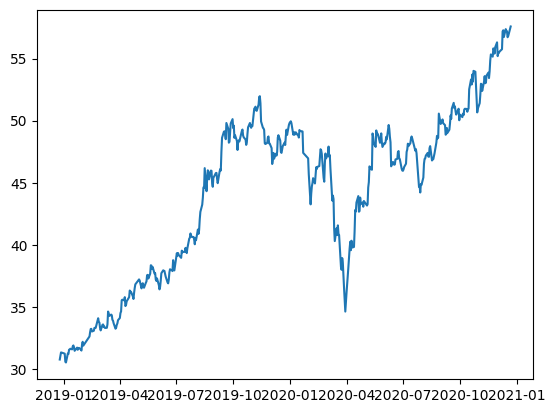

In [ ]:
plt.plot(df["Date"],df[['Close']]) #This show that filling close price of missing day doesn't affect much to the data

In [ ]:
#Make the date column the index column
df.index = df.pop('Date')
df

,Close
Date,
2018-12-25,30.760000
2018-12-26,31.050159
2018-12-27,31.331567
2018-12-28,31.321557
2018-12-29,31.303725
...,...
2020-12-18,56.811268
2020-12-19,57.003462
2020-12-20,57.195656


In [ ]:
import numpy as np

#Append the close price of the 3 previous day to each date
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2018-12-28'
windowed_df = df_to_windowed_df(df,
                                '2018-12-28	',
                                '2020-12-22',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2018-12-28,30.760000,31.050159,31.331567,31.321557
1,2018-12-29,31.050159,31.331567,31.321557,31.303725
2,2018-12-30,31.331567,31.321557,31.303725,31.285892
3,2018-12-31,31.321557,31.303725,31.285892,31.268059
4,2019-01-01,31.303725,31.285892,31.268059,31.250226
...,...,...,...,...,...
721,2020-12-18,57.247465,57.203756,56.720202,56.811268
722,2020-12-19,57.203756,56.720202,56.811268,57.003462
723,2020-12-20,56.720202,56.811268,57.003462,57.195656
724,2020-12-21,56.811268,57.003462,57.195656,57.387850


In [ ]:
#Prepare data for input of model
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((726,), (726, 3, 1), (726,))

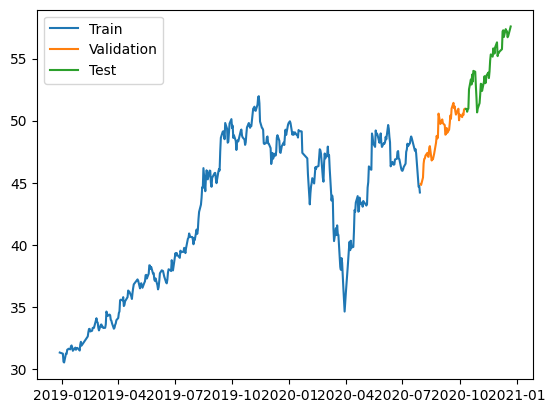

In [ ]:
#Separate training, validating and testing data
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

#Creating and training model
def create_model(X_train, y_train, X_val, y_val):
  model = Sequential([layers.Input((3, 1)),
                      layers.LSTM(64),
                      layers.Dense(32, activation='relu'),
                      layers.Dense(32, activation='relu'),
                      layers.Dense(1)])

  model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

  model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)
  return model

model = create_model(X_train, y_train, X_val, y_val)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1752.1486 - mean_absolute_error: 41.4303 - val_loss: 2112.7085 - val_mean_absolute_error: 45.9296
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1467.3625 - mean_absolute_error: 37.7989 - val_loss: 1627.5869 - val_mean_absolute_error: 40.2997
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 968.2090 - mean_absolute_error: 30.1579 - val_loss: 549.7035 - val_mean_absolute_error: 23.3622
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 186.2525 - mean_absolute_error: 11.6747 - val_loss: 15.0209 - val_mean_absolute_error: 3.4887
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 54.7418 - mean_absolute_error: 5.7326 - val_loss: 47.2796 - val_mean_absolute_error: 6.6320
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 36.8873 - mean_absolute_error: 5.5139 - val_loss: 56.8978 - val_mean_absolute_error: 7.3273
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 36.8276 - mean_a

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


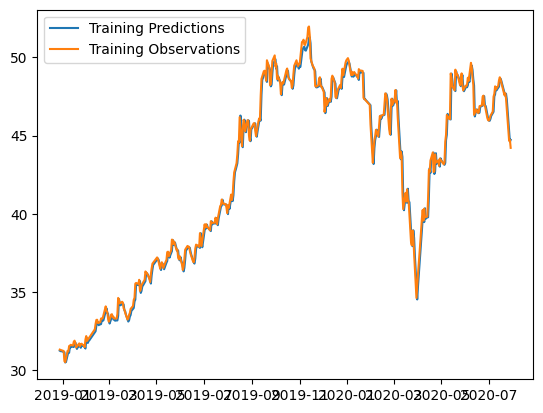

In [ ]:
#Train data compare to predition on train data
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


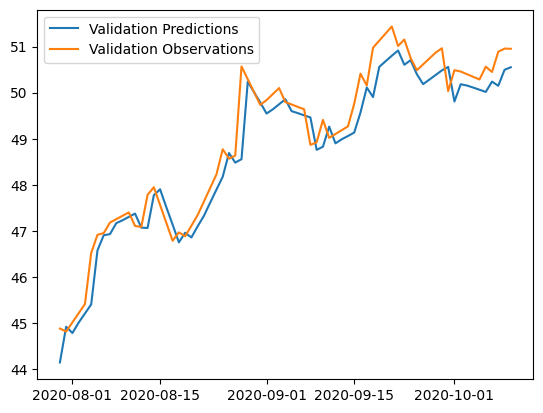

In [ ]:
#Validating data compare to predition on validating data
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


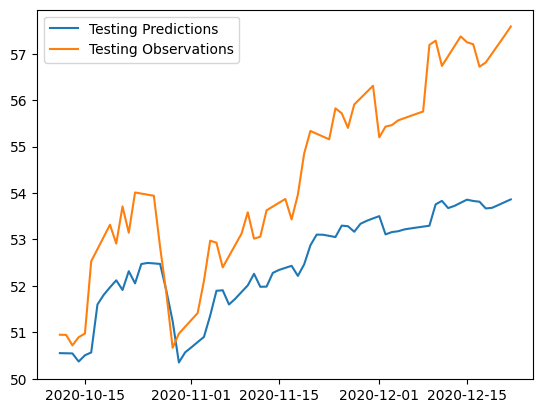

In [ ]:
#Comparing test predition and actual result
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

#We can se that the model has been able to reflect fluctuation of the stock
#Validation prediction was better because the data for it wasn't outdated
#To enhance result of the test, we should also fit the data of validation to the model
#It is best to keep training the model with recent data to keep it from being outdated

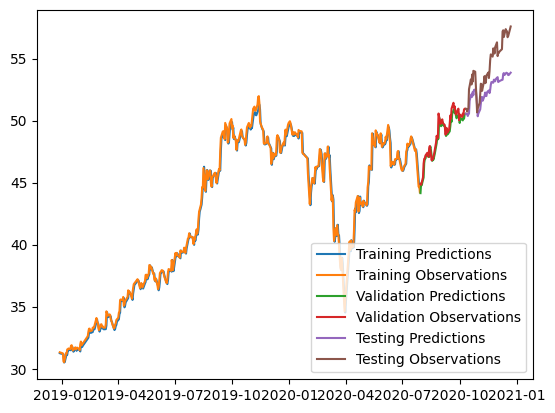

In [ ]:
#Overall view
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 6334.8379 - mean_absolute_error: 78.3584 - val_loss: 2933.6174 - val_mean_absolute_error: 54.0047
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5814.0259 - mean_absolute_error: 74.9693 - val_loss: 1816.7468 - val_mean_absolute_error: 42.4075
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3631.6196 - mean_absolute_error: 57.9755 - val_loss: 20.3659 - val_mean_absolute_error: 3.6958
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 416.0328 - mean_absolute_error: 17.2408 - val_loss: 717.1047 - val_mean_absolute_error: 26.4734
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 202.7365 - mean_absolute_error: 10.5408 - val_loss: 391.8634 - val_mean_absolute_error: 19.4751
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 146.3543 - mean_absolute_error: 9.4455 - val_loss: 118.8784 - val_mean_absolute_error: 10.6420
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 42.3761 

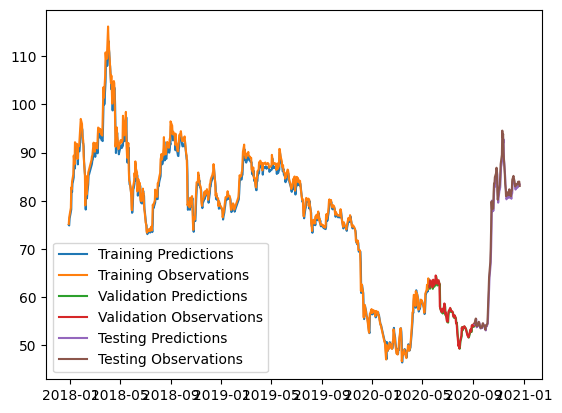

In [ ]:
#-------------------------

  #MSN dataset

#-------------------------

df = pd.read_csv('MSN.csv')
df = df[['Date/Time', 'Close']]
df["Date/Time"] = pd.to_datetime(df["Date/Time"])
df = fill_missing_dates(df)
df.index = df.pop('Date')
windowed_df = df_to_windowed_df(df,
                                '2017-12-28',
                                '2020-12-22',
                                n=3)
dates, X, y = windowed_df_to_date_X_y(windowed_df)
#Separate training, validating and testing data
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

model = create_model(X_train, y_train, X_val, y_val)

train_predictions = model.predict(X_train).flatten()
val_predictions = model.predict(X_val).flatten()
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

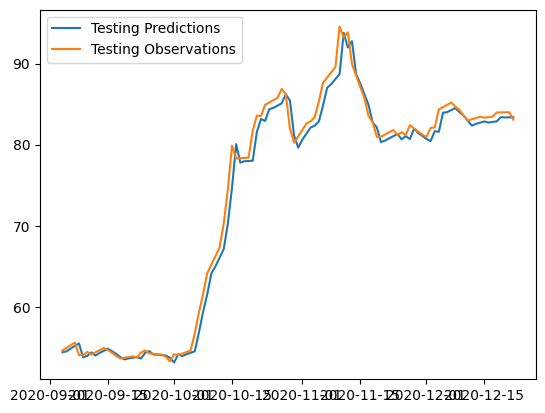

In [ ]:
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 5578.7700 - mean_absolute_error: 74.1384 - val_loss: 3156.0027 - val_mean_absolute_error: 56.0845
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5206.0010 - mean_absolute_error: 71.6075 - val_loss: 2316.6565 - val_mean_absolute_error: 48.0140
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3737.3247 - mean_absolute_error: 60.2433 - val_loss: 531.8462 - val_mean_absolute_error: 22.8199
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1102.3822 - mean_absolute_error: 31.0725 - val_loss: 201.4534 - val_mean_absolute_error: 13.7757
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 98.2275 - mean_absolute_error: 7.7174 - val_loss: 280.2256 - val_mean_absolute_error: 16.4353
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 78.2601 - mean_absolute_error: 7.0639 - val_loss: 154.6593 - val_mean_absolute_error: 12.1065
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 58.4661

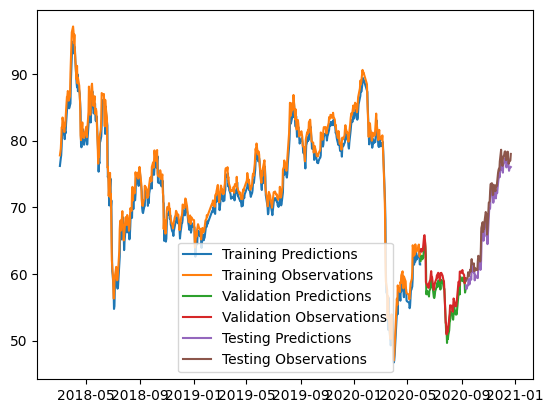

In [ ]:
#-------------------------

  #PNJ dataset

#-------------------------

df = pd.read_csv('PNJ.csv')
df = df[['Date/Time', 'Close']]
df["Date/Time"] = pd.to_datetime(df["Date/Time"])
df = fill_missing_dates(df)
df.index = df.pop('Date')
windowed_df = df_to_windowed_df(df,
                                '2018-03-03',
                                '2020-12-22',
                                n=3)
dates, X, y = windowed_df_to_date_X_y(windowed_df)
#Separate training, validating and testing data
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

model = create_model(X_train, y_train, X_val, y_val)

train_predictions = model.predict(X_train).flatten()
val_predictions = model.predict(X_val).flatten()
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

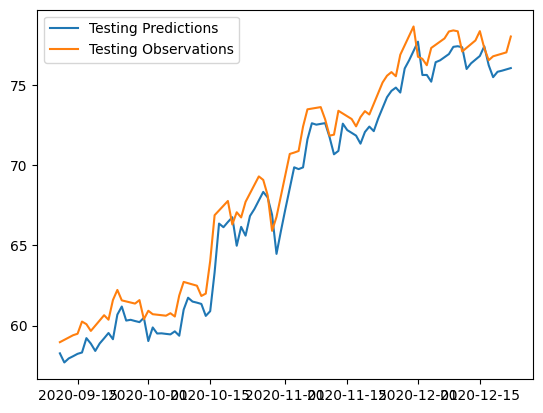

In [ ]:
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 11804.1045 - mean_absolute_error: 108.0996 - val_loss: 7971.2627 - val_mean_absolute_error: 89.2250
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 11657.8682 - mean_absolute_error: 107.4448 - val_loss: 7537.4761 - val_mean_absolute_error: 86.7591
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10709.7725 - mean_absolute_error: 102.8714 - val_loss: 6260.8486 - val_mean_absolute_error: 79.0596
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8946.2412 - mean_absolute_error: 93.8483 - val_loss: 3607.3079 - val_mean_absolute_error: 59.9658
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5259.0938 - mean_absolute_error: 71.0776 - val_loss: 571.2587 - val_mean_absolute_error: 23.6798
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1215.3032 - mean_absolute_error: 32.0706 - val_loss: 218.4752 - val_mean_absolute_error: 14.3992
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - 

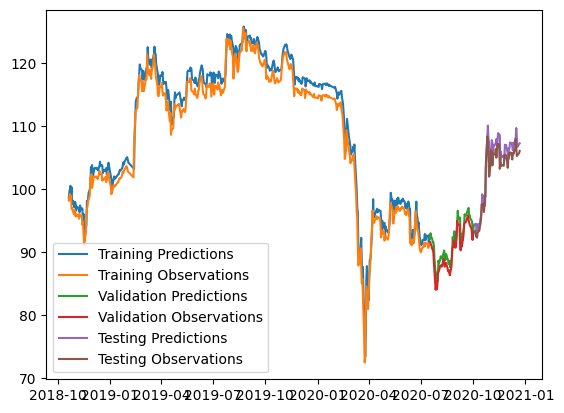

In [ ]:
#-------------------------

  #VIC dataset

#-------------------------

df = pd.read_csv('VIC.csv')
df = df[['Date/Time', 'Close']]
df["Date/Time"] = pd.to_datetime(df["Date/Time"])
df = fill_missing_dates(df)
df.index = df.pop('Date')
windowed_df = df_to_windowed_df(df,
                                '2018-10-20',
                                '2020-12-22',
                                n=3)
dates, X, y = windowed_df_to_date_X_y(windowed_df)
#Separate training, validating and testing data
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

model = create_model(X_train, y_train, X_val, y_val)

train_predictions = model.predict(X_train).flatten()
val_predictions = model.predict(X_val).flatten()
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

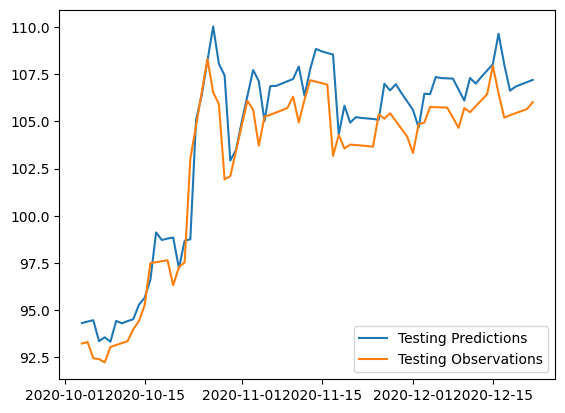

In [ ]:
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])